In [1]:
from dotenv import load_dotenv
import os
import requests

In [2]:
import numpy as np

In [77]:
load_dotenv(override = True)

True

In [78]:


def get_stock(ticker: str, newest_first: bool = False):
    '''
    Returns:
    dict: returns dict with stock daily candle data
    Returns:
    (tuple, tuple): returns (dates, daily_closing_prices) of the given stocks respectively. If newest_first is True, newest is returned first, else, oldest is returned
    '''
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker.upper()}&interval=5min&outputsize=full&apikey={os.environ.get('ALPHA_VANTAGE_API_KEY')}'
    r = requests.get(url)
    data = r.json()
    return data

    

In [196]:
stock = get_stock('aapl')

In [63]:
stock.get('Meta Data')

In [56]:
def extract_date_prices(ticker_object, last_n_years = 8):

    data = ticker_object.get('Time Series (Daily)')
    dates = list(data.keys())
    prices = [float(value.get('4. close')) for value in data.values()]
    return dates[:int(last_n_years * 252)], prices[:int(last_n_years * 252)]

dates, prices = extract_date_prices(stock)

In [57]:
len(dates)

2016

In [43]:
import pandas as pd

In [44]:
stock_series = pd.Series(index = dates, data = prices, name = 'aapl')
stock_series.index = pd.to_datetime(stock_series.index)

stock_series

2025-09-29    254.43
2025-09-26    255.46
2025-09-25    256.87
2025-09-24    252.31
2025-09-23    254.43
               ...  
1999-11-05     88.31
1999-11-04     83.62
1999-11-03     81.50
1999-11-02     80.25
1999-11-01     77.62
Name: aapl, Length: 6517, dtype: float64

In [45]:
print(stock_series.dtype)

float64


In [46]:
pd.concat((stock_series, stock_series), axis = 1)

,aapl,aapl
2025-09-29,254.43,254.43
2025-09-26,255.46,255.46
2025-09-25,256.87,256.87
2025-09-24,252.31,252.31
2025-09-23,254.43,254.43
...,...,...
1999-11-05,88.31,88.31
1999-11-04,83.62,83.62
1999-11-03,81.50,81.50
1999-11-02,80.25,80.25


In [198]:
class Portfolio:

    def __init__(self, ticker_list, last_n_years = 8):

        self.ticker_list = ticker_list
        self.portfolio_size = self.ps = len(ticker_list)

        dates_prices_lists = [ (ticker, *extract_date_prices(get_stock(ticker), last_n_years = last_n_years)) for ticker in ticker_list]
        dates_returns_lists = [(ticker, dates, self.get_returns(prices)) for ticker, dates, prices in dates_prices_lists]
        
        prices_series = [pd.Series(index = pd.to_datetime(dates), data = prices, name = ticker) for ticker, dates, prices in dates_prices_lists]
        returns_series = [pd.Series(index = pd.to_datetime(dates), data = returns, name = ticker) for ticker, dates, returns in dates_returns_lists]

        self.prices_df = pd.concat(prices_series, axis = 1)
        self.returns_df = pd.concat(returns_series, axis = 1)

    def get_returns(self, prices):
        
        returns_list = [0]
        prices_rev = prices[::-1]

        for i in range(1, len(prices_rev)):
            returns_list.append((prices_rev[i] - prices_rev[i - 1]) / prices_rev[i - 1])
        
        return returns_list[::-1]

portfolio_tickers = ['snps', 'vst', 'unh', 'rare', 'vxus', 'voog', 'nvda', 'vti', 'iau', 'arkk', 'v', 'mrna']
portfolio = Portfolio(portfolio_tickers)        

In [199]:
returns_df = portfolio.returns_df.sort_index(ascending = False).dropna()

In [200]:
returns_df.isna().any()

snps    False
vst     False
unh     False
rare    False
vxus    False
voog    False
nvda    False
vti     False
iau     False
arkk    False
v       False
mrna    False
dtype: bool

In [204]:
reversal_dates = { 
    'snps' : [], 
    'vst': [],
    'unh': [], 
    'rare': [pd.to_datetime('2018-01-05')], 
    'vxus': [], 
    'voog': [], 
    'nvda': [pd.to_datetime('2024-06-10'), pd.to_datetime('2021-07-20')], 
    'vti': [], 
    'iau': [pd.to_datetime('2021-05-24')], 
    'arkk': [], 
    'v': [], 
    'mrna': [] 
}

In [205]:
drop_dates = []
for values in reversal_dates.values():
    for value in values:
        drop_dates.append(value)

returns_df = returns_df.drop(drop_dates)

In [92]:
import matplotlib.pyplot as plt

In [95]:
import random
def gen_random_color():
    hexa = "0123456789abcdef"
    rand_color = "#"
    for _ in range(6):
        rand_color += random.choice(hexa)
    return rand_color

gen_random_color()

'#86e1a7'

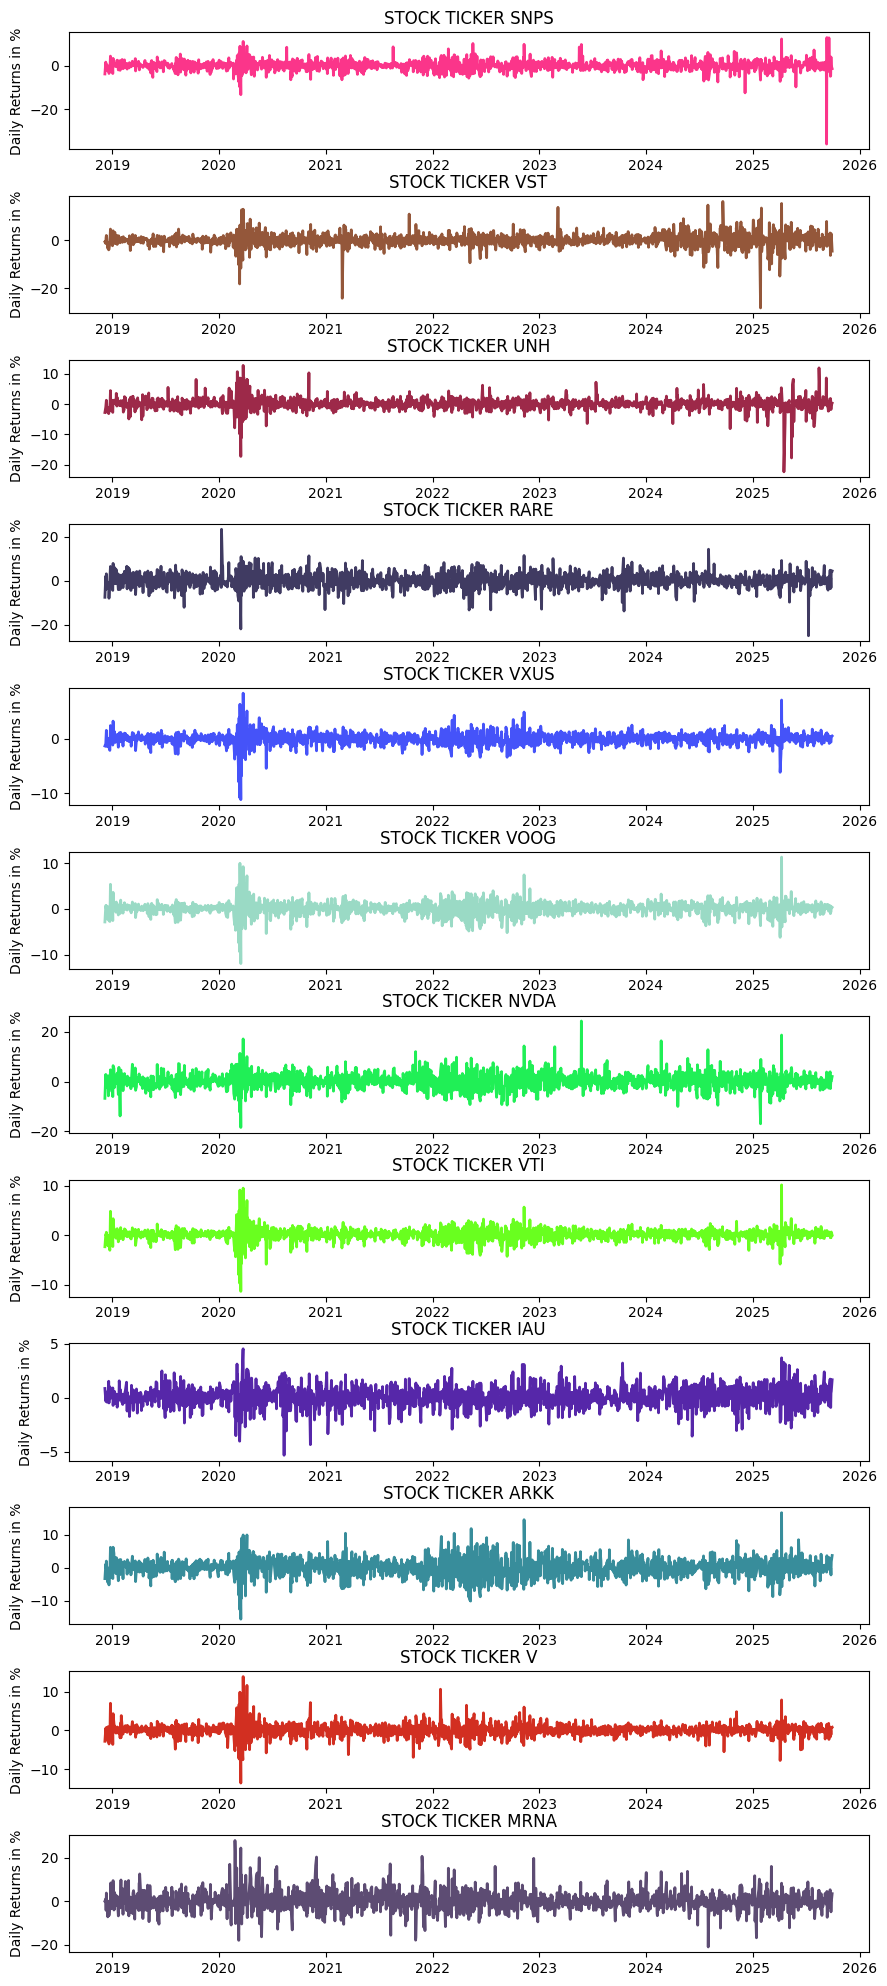

In [208]:
fig, axes = plt.subplots(nrows = len(returns_df.columns), figsize = (10, 24))

for i,col in enumerate(returns_df.columns):
    axes[i].plot(returns_df.index, returns_df[col] * 100, color = gen_random_color(), lw = 2, alpha = 0.9)
    axes[i].set_title(f'STOCK TICKER {col.upper()}')
    axes[i].set_ylabel('Daily Returns in %')

plt.subplots_adjust(
    left=0.1,    # the left side of the subplots of the figure
    right=0.9,   # the right side of the subplots of the figure
    bottom=0.1,  # the bottom of the subplots of the figure
    top=0.9,     # the top of the subplots of the figure
    wspace=0.4,  # the amount of width reserved for blank space between subplots
    hspace=0.4   # the amount of height reserved for white space between subplots
)

In [131]:
import seaborn as sns

In [209]:
np.array(returns_df.cov())

array([[5.90349207e-04, 1.94907230e-04, 1.22877602e-04, 2.50210066e-04,
        1.53744722e-04, 2.51057962e-04, 5.08116993e-04, 2.08630954e-04,
        2.33850698e-05, 4.11485475e-04, 2.00516871e-04, 2.08412085e-04],
       [1.94907230e-04, 8.12909223e-04, 1.01918851e-04, 1.73274574e-04,
        1.38877831e-04, 1.92102620e-04, 3.40132924e-04, 1.78170552e-04,
        2.77965559e-05, 2.68203134e-04, 1.59344831e-04, 8.28603045e-05],
       [1.22877602e-04, 1.01918851e-04, 4.22743251e-04, 1.51956493e-04,
        9.32373371e-05, 1.20534782e-04, 1.53679195e-04, 1.20817399e-04,
        6.93324815e-06, 1.31377914e-04, 1.39363202e-04, 2.97582024e-05],
       [2.50210066e-04, 1.73274574e-04, 1.51956493e-04, 1.13581340e-03,
        1.61430213e-04, 2.14524094e-04, 3.80512429e-04, 1.97085416e-04,
        2.73162552e-05, 4.92595766e-04, 1.82472496e-04, 3.08018284e-04],
       [1.53744722e-04, 1.38877831e-04, 9.32373371e-05, 1.61430213e-04,
        1.36045688e-04, 1.36125149e-04, 2.19970517e-04, 1.30

Text(0.5, 1.0, 'Pearson Correlation of My Portfolio')

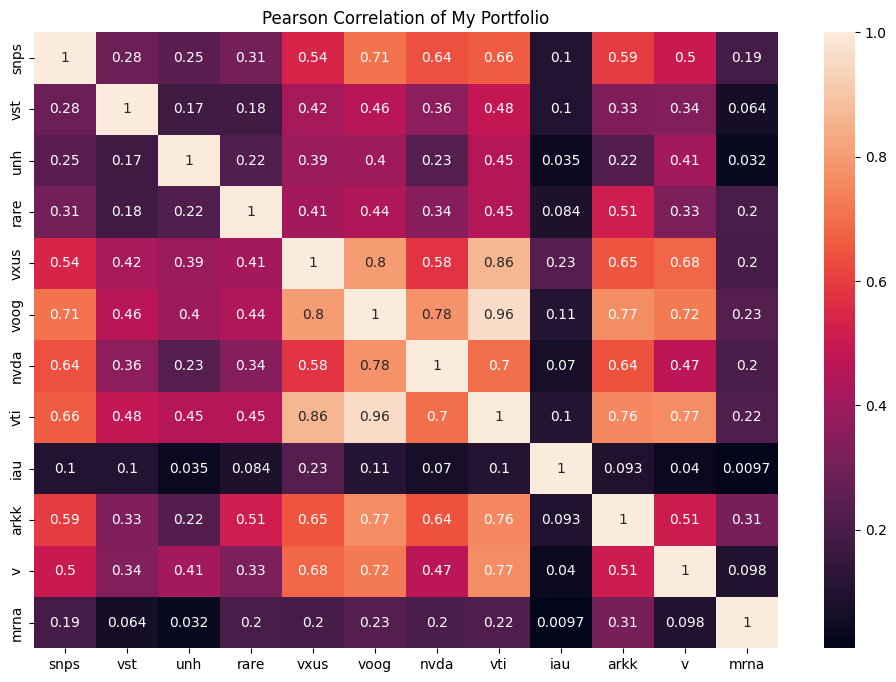

In [214]:
plt.figure(figsize=(12, 8))
sns.heatmap(returns_df.corr(), annot = True)

plt.title('Pearson Correlation of My Portfolio')

Text(0.5, 1.0, 'Covariance Matrix')

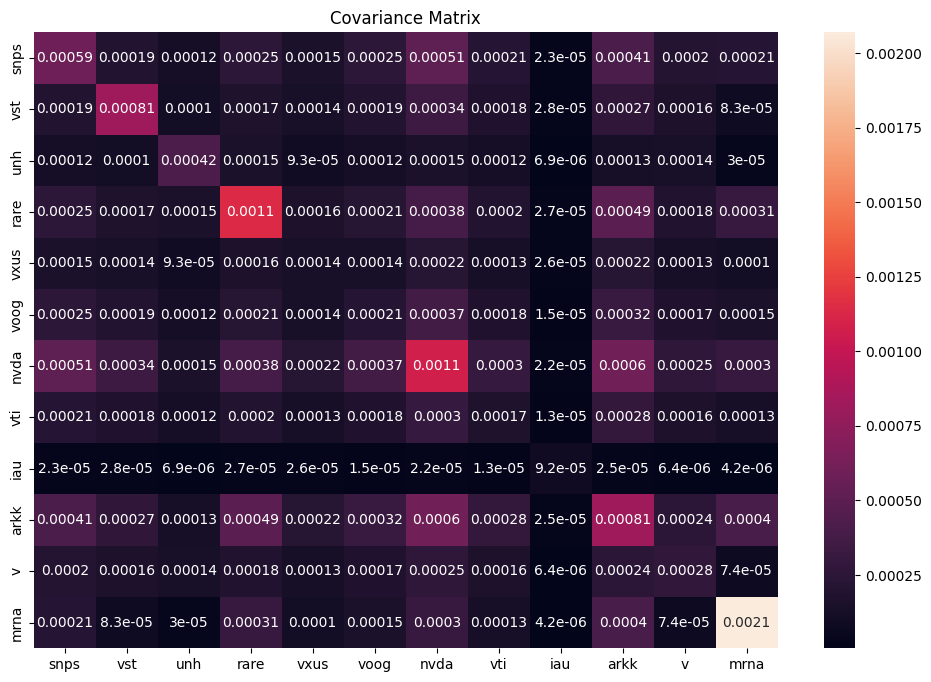

In [256]:
plt.figure(figsize=(12, 8))
sns.heatmap(returns_df.cov(), annot = True)

plt.title('Covariance Matrix')

In [345]:
np.array(returns_df.cov())

array([[5.90349207e-04, 1.94907230e-04, 1.22877602e-04, 2.50210066e-04,
        1.53744722e-04, 2.51057962e-04, 5.08116993e-04, 2.08630954e-04,
        2.33850698e-05, 4.11485475e-04, 2.00516871e-04, 2.08412085e-04],
       [1.94907230e-04, 8.12909223e-04, 1.01918851e-04, 1.73274574e-04,
        1.38877831e-04, 1.92102620e-04, 3.40132924e-04, 1.78170552e-04,
        2.77965559e-05, 2.68203134e-04, 1.59344831e-04, 8.28603045e-05],
       [1.22877602e-04, 1.01918851e-04, 4.22743251e-04, 1.51956493e-04,
        9.32373371e-05, 1.20534782e-04, 1.53679195e-04, 1.20817399e-04,
        6.93324815e-06, 1.31377914e-04, 1.39363202e-04, 2.97582024e-05],
       [2.50210066e-04, 1.73274574e-04, 1.51956493e-04, 1.13581340e-03,
        1.61430213e-04, 2.14524094e-04, 3.80512429e-04, 1.97085416e-04,
        2.73162552e-05, 4.92595766e-04, 1.82472496e-04, 3.08018284e-04],
       [1.53744722e-04, 1.38877831e-04, 9.32373371e-05, 1.61430213e-04,
        1.36045688e-04, 1.36125149e-04, 2.19970517e-04, 1.30

Text(0.5, 1.0, 'Covariance Matrix')

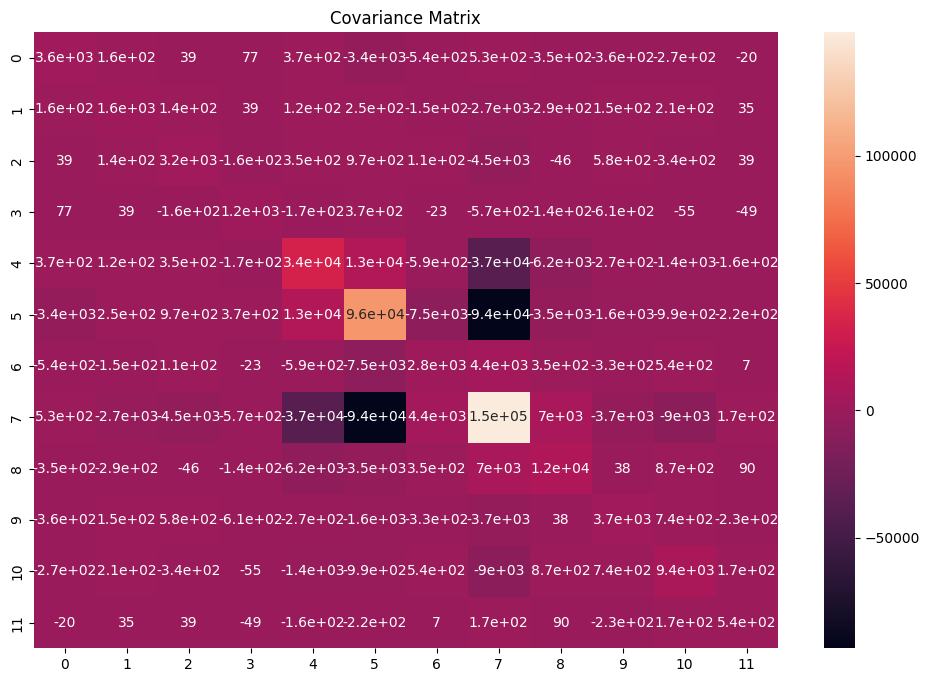

In [257]:
plt.figure(figsize=(12, 8))
sns.heatmap(np.linalg.inv(returns_df.cov()), annot = True)

plt.title('Covariance Matrix')

In [216]:
returns_df.mean() * 100

snps    0.125373
vst     0.161484
unh     0.033507
rare    0.026124
vxus    0.029062
voog    0.072752
nvda    0.275507
vti     0.057114
iau     0.069233
arkk    0.076861
v       0.064866
mrna    0.121448
dtype: float64

In [335]:
class RiskManager:

    '''
    This class uses Lagrange multipliers and Markowitz's Modern Portfolio Theory (MPT) to manage risks and rewards.

    The class has two main methods:
        - minimize_risks:
            Given a target daily reward, optimize the allocations such that the daily rewards are met with minimum risk (uses Lagrange Multipliers)

        - maximize_reward:
            Given a risk tolerance lambda, optimize the daily rewards using Markowitz's MPT.

    The Lagrangian for minimize_risks:
        - L(w, lambda, gamma) =  weights.T @ cov @ weights - lambda * (mean_returns.T @ weights - reward) - gamma(1.T @ weights - 1)
    The Lagrangian for maximize_reward:
        L(w, lambda, gamma) = mean_returns.T @ weights - lambda * weights.T @ cov @ weights - gamma(1.T @ weights - 1)

    For the first Lagrangian, 
        
    '''

    def __init__(self, data, budget = 0):
        self.data = data
        self.budget = budget
        self.cov = np.array(data.cov())
        self.tickers = list(data.columns)
        self.mean_returns = np.array([self.data.mean()[ticker] for ticker in self.tickers]).reshape(-1, 1)

    def minimize_risks(self, daily_reward):

        n = self.mean_returns.size
        
        # Build A
        A = np.zeros((n+2, n+2))
        b = np.zeros(n+2)
        
        # First row: mu.T @ w = R
        A[0, :n] = self.mean_returns.reshape(1, -1)
        b[0] = daily_reward
        
        # Second row: 1.T @ w = 1
        A[1, :n] = 1
        b[1] = 1
        
        # Rows 2..n+1: 2*cov @ w - lambda*mu - gamma*1 = 0
        A[2:, :n] = 2 * self.cov
        A[2:, n] = -self.mean_returns.reshape(1, -1)     # lambda column
        A[2:, n+1] = -1      # gamma column
        b[2:] = 0
        
        # Solve
        x = np.linalg.solve(A, b)
        
        w = x[:n]
        lambda_ = x[n]
        gamma = x[n+1]
        results = {self.tickers[i]: float(w[i]) * self.budget for i in range(len(self.tickers))}
        results['risk_lambda'] = float(lambda_)
        results['risk_gamma'] = float(gamma)
        results['daily_variance'] = float(w.T @ self.cov @ w)
        results['daily_return'] = float(daily_reward * self.budget)
        return results


    def maximize_reward(self, risk_aversion_lambda):

        epsilon = 0.001
        
        cov_inv = np.linalg.inv(self.cov)
        
        gamma = (np.sum(cov_inv, axis = 0) @ self.mean_returns - 2 * risk_aversion_lambda) / (np.sum(cov_inv) + epsilon)
        weights = (cov_inv @ self.mean_returns - gamma * np.sum(cov_inv, axis = 1).reshape(-1,1)) / (2 * risk_aversion_lambda + epsilon)
        if self.budget > 0:
            weights *= self.budget
        result_data = {self.tickers[i] : float(weights[i]) for i in range(len(self.tickers))}
        result_data['daily_return'] = float(self.mean_returns.reshape(1, -1) @ weights)
        result_data['daily_variance'] = float(weights.T @ self.cov @ weights)
        return result_data
        

In [338]:
risk_manager = RiskManager(returns_df, 5600)
result = risk_manager.maximize_reward(10000)
result

C:\Users\ZezoLeMeilleur\AppData\Local\Temp\ipykernel_9720\1667911995.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result_data = {self.tickers[i] : float(weights[i]) for i in range(len(self.tickers))}
C:\Users\ZezoLeMeilleur\AppData\Local\Temp\ipykernel_9720\1667911995.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result_data['daily_return'] = float(self.mean_returns.reshape(1, -1) @ weights)
C:\Users\ZezoLeMeilleur\AppData\Local\Temp\ipykernel_9720\1667911995.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your arra

{'snps': -63.51723751588453,
 'vst': -105.98488163728801,
 'unh': 125.581212567157,
 'rare': -18.681308860088194,
 'vxus': 427.01365393055113,
 'voog': -127.87136502345531,
 'nvda': -285.7725248873824,
 'vti': 2972.292738261994,
 'iau': 3176.246460803272,
 'arkk': -570.8691129552224,
 'v': -45.078264515828934,
 'mrna': 116.64003448393505,
 'daily_return': 2.6004039929883853,
 'daily_variance': 1766.678146168884}

In [343]:
results = risk_manager.minimize_risks(0.01)
results

{'snps': 2279.04840322474,
 'vst': 5522.311705923727,
 'unh': -169.8880336794405,
 'rare': -1476.865900694962,
 'vxus': -35481.77266941407,
 'voog': -31881.709724746666,
 'nvda': 16601.371015351968,
 'vti': 21517.501800295388,
 'iau': 19269.751010504777,
 'arkk': -2381.972960759109,
 'v': 10068.82848852048,
 'mrna': 1733.3968654731707,
 'risk_lambda': 1.370568322080051,
 'risk_gamma': -0.0005228098466955818,
 'daily_variance': 0.006591436687052466,
 'daily_return': 56.0}

In [362]:
import numpy as np
from scipy.optimize import minimize

class RiskManager:
    '''
    Portfolio optimization using Modern Portfolio Theory (MPT).
    
    Two main methods:
    1. minimize_risks: Minimize variance subject to target return constraint
    2. maximize_reward: Maximize utility = return - λ*variance
    '''
    
    def __init__(self, data, budget=0):
        self.data = data
        self.budget = budget
        self.cov = np.array(data.cov())
        self.tickers = list(data.columns)
        self.mean_returns = np.array([self.data.mean()[ticker] for ticker in self.tickers])
        self.n = len(self.tickers)
    
    def minimize_risks(self, daily_reward, allow_short=False):
        """
        Minimize portfolio variance subject to:
        - Expected return = daily_reward
        - Sum of weights = 1
        - Optional: No short selling (w >= 0)
        """
        
        def objective(w):
            return w @ self.cov @ w
        
        # Constraints
        constraints = [
            {'type': 'eq', 'fun': lambda w: self.mean_returns @ w - daily_reward},  # Target return
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # Fully invested
        ]
        
        # Bounds
        if allow_short:
            bounds = [(None, None)] * self.n
        else:
            bounds = [(0, None)] * self.n  # No short selling
        
        # Initial guess: equal weights
        w0 = np.ones(self.n) / self.n
        
        # Optimize
        result = minimize(objective, w0, method='SLSQP', bounds=bounds, constraints=constraints)
        
        if not result.success:
            print(f"Warning: Optimization did not converge. Message: {result.message}")
        
        w = result.x
        
        # Build results
        results = {self.tickers[i]: float(w[i]) * self.budget for i in range(self.n)}
        results['daily_variance'] = float(w @ self.cov @ w)
        results['daily_return'] = float(self.mean_returns @ w * self.budget)
        results['daily_std'] = float(np.sqrt(w @ self.cov @ w) * self.budget)
        results['optimization_success'] = result.success
        
        return results
    
    def maximize_reward(self, risk_aversion_lambda, allow_short=False):
        """
        Maximize utility = return - λ*variance
        Subject to: sum of weights = 1
        Optional: No short selling (w >= 0)
        
        Args:
            risk_aversion_lambda: Risk aversion parameter (higher = more conservative)
            allow_short: Whether to allow negative weights (short selling)
        """
        
        def objective(w):
            return -(self.mean_returns @ w - risk_aversion_lambda * (w @ self.cov @ w))
        
        # Constraint: fully invested
        constraints = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
        ]
        
        # Bounds
        if allow_short:
            bounds = [(None, None)] * self.n
        else:
            bounds = [(0, None)] * self.n  # No short selling
        
        # Initial guess
        w0 = np.ones(self.n) / self.n
        
        # Optimize
        result = minimize(objective, w0, method='SLSQP', bounds=bounds, constraints=constraints)
        
        if not result.success:
            print(f"Warning: Optimization did not converge. Message: {result.message}")
        
        w = result.x
        
        # Build results
        results = {self.tickers[i]: float(w[i]) * self.budget for i in range(self.n)}
        results['daily_return'] = float(self.mean_returns @ w * self.budget)
        results['daily_variance'] = float(w @ self.cov @ w * self.budget**2)
        results['daily_std'] = float(np.sqrt(w @ self.cov @ w) * self.budget)
        results['utility'] = float(self.mean_returns @ w - risk_aversion_lambda * (w @ self.cov @ w))
        results['optimization_success'] = result.success
        
        return results
    
    def efficient_frontier(self, n_points=50, allow_short=False):
        """
        Compute the efficient frontier: optimal portfolios for different return levels
        
        Returns: List of dictionaries with portfolio weights and statistics
        """
        min_return = np.min(self.mean_returns)
        max_return = np.max(self.mean_returns)
        
        target_returns = np.linspace(min_return, max_return, n_points)
        frontier = []
        
        for target in target_returns:
            try:
                result = self.minimize_risks(target, allow_short=allow_short)
                if result['optimization_success']:
                    frontier.append({
                        'target_return': target,
                        'variance': result['daily_variance'],
                        'std': np.sqrt(result['daily_variance']),
                        'weights': {k: v/self.budget if self.budget > 0 else v 
                                   for k, v in result.items() 
                                   if k in self.tickers}
                    })
            except:
                continue
        
        return frontier


def test_risk_manager(returns_df, budget=5600, risk_aversion_factor = 0.5, daily_reward = 0.008):
    """
    Test the RiskManager with different configurations
    """
    rm = RiskManager(returns_df, budget)
    
    print("=" * 80)
    print(f"1. MAXIMIZE REWARD (Risk Aversion λ={risk_aversion_factor}, NO SHORT SELLING)")
    print("=" * 80)
    result1 = rm.maximize_reward(risk_aversion_lambda=risk_aversion_factor, allow_short=False)
    for k, v in result1.items():
        if k in rm.tickers:
            print(f"{k:8s}: ${v:>10.2f} ({v/budget*100:>6.2f}%)")
        else:
            print(f"{k:25s}: {v:.4f}")
    
    print("\n" + "=" * 80)
    print(f"2. MINIMIZE RISK (Target Return={daily_reward}, NO SHORT SELLING)")
    print("=" * 80)
    result2 = rm.minimize_risks(daily_reward=0.001, allow_short=False)
    for k, v in result2.items():
        if k in rm.tickers:
            print(f"{k:8s}: ${v:>10.2f} ({v/budget*100:>6.2f}%)")
        else:
            print(f"{k:25s}: {v:.4f}")
    
    print("\n" + "=" * 80)
    print(f"3. MAXIMIZE REWARD (Risk Aversion λ={risk_aversion_factor}, ALLOW SHORT SELLING)")
    print("=" * 80)
    result3 = rm.maximize_reward(risk_aversion_lambda=risk_aversion_factor, allow_short=True)
    for k, v in result3.items():
        if k in rm.tickers:
            print(f"{k:8s}: ${v:>10.2f} ({v/budget*100:>6.2f}%)")
        else:
            print(f"{k:25s}: {v:.4f}")
    
    return rm, result1, result2, result3


In [365]:
test_risk_manager(returns_df, risk_aversion_factor = 30)

1. MAXIMIZE REWARD (Risk Aversion λ=30, NO SHORT SELLING)
snps    : $      0.00 (  0.00%)
vst     : $     96.70 (  1.73%)
unh     : $    278.12 (  4.97%)
rare    : $      0.00 (  0.00%)
vxus    : $    884.24 ( 15.79%)
voog    : $     69.22 (  1.24%)
nvda    : $      0.00 (  0.00%)
vti     : $    412.14 (  7.36%)
iau     : $   3518.21 ( 62.83%)
arkk    : $      0.00 (  0.00%)
v       : $    238.88 (  4.27%)
mrna    : $    102.49 (  1.83%)
daily_return             : 3.5072
daily_variance           : 2012.7515
daily_std                : 44.8637
utility                  : -0.0013
optimization_success     : 1.0000

2. MINIMIZE RISK (Target Return=0.08, NO SHORT SELLING)
snps    : $    490.39 (  8.76%)
vst     : $    517.56 (  9.24%)
unh     : $    423.76 (  7.57%)
rare    : $    416.35 (  7.43%)
vxus    : $    420.42 (  7.51%)
voog    : $    452.14 (  8.07%)
nvda    : $    600.28 ( 10.72%)
vti     : $    440.81 (  7.87%)
iau     : $    451.45 (  8.06%)
arkk    : $    453.45 (  8.10%)
v     

(<__main__.RiskManager at 0x27fb427e5d0>,
 {'snps': 1.6393136847980827e-14,
  'vst': 96.69823806206837,
  'unh': 278.12152952552924,
  'rare': 1.5785983631388945e-14,
  'vxus': 884.2439063531374,
  'voog': 69.2158541975729,
  'nvda': 2.8839777788114418e-15,
  'vti': 412.14113209715566,
  'iau': 3518.210883417698,
  'arkk': 1.214306433183765e-15,
  'v': 238.88087186324995,
  'mrna': 102.48758448358889,
  'daily_return': 3.5072418063934467,
  'daily_variance': 2012.7514960051585,
  'daily_std': 44.863699089633236,
  'utility': -0.001299170623863248,
  'optimization_success': True},
 {'snps': 490.3850507406349,
  'vst': 517.5557173571966,
  'unh': 423.7647885756457,
  'rare': 416.35489341876763,
  'vxus': 420.42247833859716,
  'voog': 452.13728896847203,
  'nvda': 600.2784341969469,
  'vti': 440.81066830487384,
  'iau': 451.4457961501006,
  'arkk': 453.447451352828,
  'v': 446.6123890473868,
  'mrna': 486.7850435485495,
  'daily_variance': 0.00023412456582511126,
  'daily_return': 5.59999

In [373]:
rm = RiskManager(returns_df, budget = 5600)

In [377]:
ef = rm.efficient_frontier(n_points = 50)

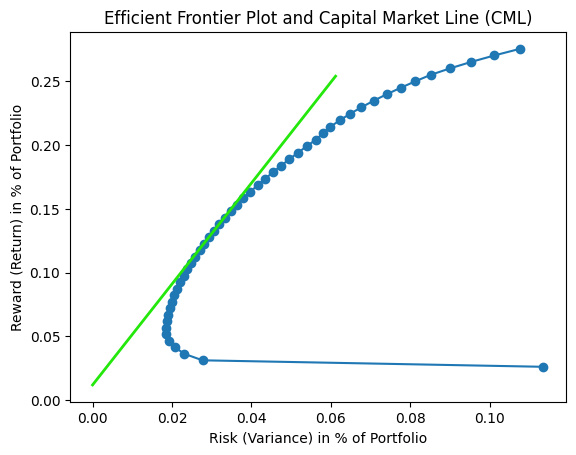

In [396]:
returns = [obj['target_return'] * 100 for obj in ef]
variance = [obj['variance'] * 100 for obj in ef]

plt.plot(variance, returns, marker = 'o')
plt.xlabel('Risk (Variance) in % of Portfolio')
plt.ylabel('Reward (Return) in % of Portfolio')
plt.title('Efficient Frontier Plot and Capital Market Line (CML)')

risk_free_return = 3 / 252 # 3% over a year

max_sharpe_ratio = 0
portfolio_index = -1
for i in range(len(returns)):

    sharpe_ratio = (returns[i] - risk_free_return) / variance[i]
    if sharpe_ratio > max_sharpe_ratio:
        max_sharpe_ratio = sharpe_ratio
        portfolio_index = i
        
x_init = [0]
y_init = [risk_free_return]
x_init.append(variance[portfolio_index])
y_init.append(returns[portfolio_index])

x_init.append(variance[portfolio_index] * 2)
y_init.append(returns[portfolio_index] + max_sharpe_ratio * variance[portfolio_index])

plt.plot(x_init, y_init, color = gen_random_color(), lw = 2)

In [395]:
import json

print(f"BEST SHARPE RATIO: {max_sharpe_ratio : .2f}")
print(f"BEST RETURN AND RISK: {returns[portfolio_index]: .2f}, {variance[portfolio_index] : .2f}")

print("=" * 80)
print(json.dumps(ef[portfolio_index], indent = 4))
print("=" * 80)

BEST SHARPE RATIO:  3.96
BEST RETURN AND RISK:  0.13,  0.03
{
    "target_return": 0.0013300255609474867,
    "variance": 0.0003060498921810062,
    "std": 0.01749428169948701,
    "weights": {
        "snps": 0.10703205159861837,
        "vst": 0.13344606163213718,
        "unh": 0.040280975056429746,
        "rare": 0.03454941791477264,
        "vxus": 0.03702974416981623,
        "voog": 0.068781362097708,
        "nvda": 0.21630293730252564,
        "vti": 0.05742096595410942,
        "iau": 0.06655634726596313,
        "arkk": 0.07146858312637656,
        "v": 0.06308587396190818,
        "mrna": 0.1040456799196349
    }
}


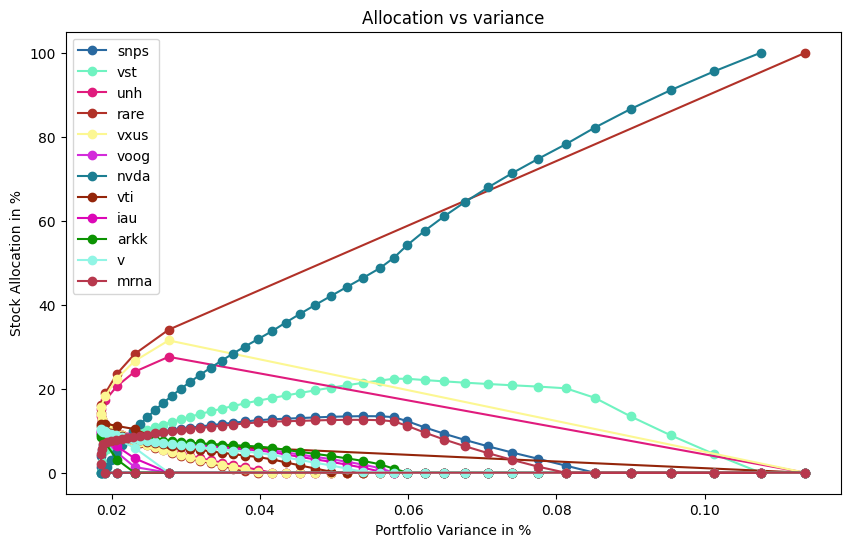

In [412]:
allocations = {ticker: [pf['weights'][ticker] for pf in ef] for ticker in portfolio_tickers}
fig, ax = plt.subplots(figsize = (10, 6))
for k,v in allocations.items():
    ax.plot(variance, np.array(allocations[k]) * 100, label = k, color = gen_random_color(), marker ='o')

ax.set_title('Allocation vs variance')
ax.set_xlabel('Portfolio Variance in %')
ax.set_ylabel('Stock Allocation in %')

plt.legend()